In [1]:
# Add ldcpy root to system path
import struct
import sys
from math import log2

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '/glade/u/home/abaker/repos/ldcpy')
import ldcpy

%load_ext autoreload
%autoreload 2


# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")


# display the plots in this notebook
%matplotlib inline

In [2]:
import os

os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/haiyingx/H5Z-ZFP-PLUGIN-unbiased/plugin'

In [3]:
# See here for a list of variables with more information:
# https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html

daily_variables = [
    "TS",
    "PRECT",
    "LHFLX",
    "FLNS",
    "ICEFRAC",
    "PSL",
    "Q200",
    "TAUX",
    "WSPDSRFAV",
    "Z500",
]
data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"

cols_daily = {}
sets = {}
levels = {}
climate_var_arrays = {}

compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]

for variable in daily_variables:
    print(variable)

    new_levels = [f"orig_{variable}"]
    new_sets = [
        f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
    ]

    for value in compression_levels:
        new_level = f"zfp_p_{value}_{variable}"
        new_set = f"{data_path}/daily_zfp_hdf5/zfp_p_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"

        new_levels.append(new_level)
        new_sets.append(new_set)

    levels[variable] = new_levels
    sets[variable] = new_sets

    cols_daily[variable] = ldcpy.open_datasets(
        "cam-fv", [f"{variable}"], sets[variable], levels[variable], chunks={}
    )
    climate_var_arrays[variable] = np.array(cols_daily[variable][variable].isel(time=0).values)

TS
dataset size in GB 1.62

PRECT
dataset size in GB 1.62

LHFLX
dataset size in GB 1.62

FLNS
dataset size in GB 1.62

ICEFRAC
dataset size in GB 1.62

PSL
dataset size in GB 1.62

Q200
dataset size in GB 1.62

TAUX
dataset size in GB 1.62

WSPDSRFAV
dataset size in GB 1.62

Z500
dataset size in GB 1.62



In [4]:
# BG

bg_daily_variables = [
    "TS",
    "PRECT",
    "LHFLX",
    "FLNS",
    "ICEFRAC",
    "PSL",
    "Q200",
    "TAUX",
    "WSPDSRFAV",
    "Z500",
]

bg_cols_daily = {}
bg_sets = {}
bg_levels = {}
data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research/"
bg_climate_var_arrays = {}

bg_compression_levels = [7, 6, 5, 4, 3, 2]

for variable in bg_daily_variables:
    print(variable)

    bg_new_levels = [f"orig_{variable}"]
    bg_new_sets = [
        f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
    ]

    for value in bg_compression_levels:
        bg_new_level = f"zfp_p_{value}_{variable}"
        bg_new_set = f"{data_path}/daily_bg/bg_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"

        bg_new_levels.append(bg_new_level)
        bg_new_sets.append(bg_new_set)

    bg_levels[variable] = bg_new_levels
    bg_sets[variable] = bg_new_sets

    bg_cols_daily[variable] = ldcpy.open_datasets(
        "cam-fv", [f"{variable}"], bg_sets[variable], bg_levels[variable], chunks={}
    )
    bg_climate_var_arrays[variable] = np.array(
        bg_cols_daily[variable][variable].isel(time=0).values
    )

TS
dataset size in GB 1.13

PRECT
dataset size in GB 1.13

LHFLX
dataset size in GB 1.13

FLNS
dataset size in GB 1.13

ICEFRAC
dataset size in GB 1.13

PSL
dataset size in GB 1.13

Q200
dataset size in GB 1.13

TAUX
dataset size in GB 1.13

WSPDSRFAV
dataset size in GB 1.13

Z500
dataset size in GB 1.13



In [6]:
# import bitstring
import numpy as np


def binary(num):
    return ''.join(f'{c:0>8b}' for c in struct.pack('!f', num))


N_BITS = 32


def getbpe(data_array, x_index, title, compression_levels):
    dict_list_H = []

    # flatten in row order
    fa = (data_array[x_index, :, :]).flatten()
    num = len(fa)

    # count propabilities of adjacent bits
    for i in range(N_BITS):
        new_dict = {"00": 0, "01": 0, "10": 0, "11": 0}
        dict_list_H.append(new_dict)

    for y in range(1, num):
        current_data = fa[y]
        current_data = binary(current_data)
        # print(current_data)
        adj_data = fa[y - 1]
        adj_data = binary(adj_data)
        # print(adj_data)

        # for each bit position
        for i in range(N_BITS):
            current_bit = int(current_data[i])
            adjacent_bit = int(adj_data[i])

            p00 = p01 = p10 = p11 = 0
            if adjacent_bit == 0 and current_bit == 0:
                p00 = 1
            elif adjacent_bit == 1 and current_bit == 0:
                p10 = 1
            elif adjacent_bit == 0 and current_bit == 1:
                p01 = 1
            elif adjacent_bit == 1 and current_bit == 1:
                p11 = 1
            dict_list_H[i]["00"] += p00
            dict_list_H[i]["01"] += p01
            dict_list_H[i]["10"] += p10
            dict_list_H[i]["11"] += p11

    I = []
    for bcount, bit_pos_dict in enumerate(dict_list_H):

        p00 = np.divide(bit_pos_dict["00"], num - 1, dtype=np.float64)
        p01 = np.divide(bit_pos_dict["01"], num - 1, dtype=np.float64)
        p10 = np.divide(bit_pos_dict["10"], num - 1, dtype=np.float64)
        p11 = np.divide(bit_pos_dict["11"], num - 1, dtype=np.float64)

        # print("p00 = ", p00, "p01 = ", p01, "p10 = ", p10, "p11 = ", p11)
        p0 = p00 + p10  # current bit is 0
        p1 = p11 + p01  # current bit is 1
        p0_prev = p00 + p01  # prev bit was 0
        p1_prev = p11 + p10  # prev bit was 1

        # print("p0 = ", p0)
        # print("p1 = ", p1)
        # print("p0_prev = ", p0_prev)
        # print("p1_prev = ", p1_prev)

        # METHOD 1
        # From (4) in paper
        # mutual information
        MI = 0.0
        if p00 > 0.0:
            MI += p00 * np.log2(p00 / p0_prev / p0)
        if p11 > 0.0:
            MI += p11 * np.log2(p11 / p1_prev / p1)
        if p01 > 0.0:
            MI += p01 * np.log2(p01 / p0_prev / p1)
        if p10 > 0.0:
            MI += p10 * np.log2(p10 / p1_prev / p0)

        # print("MI_1 = ", MI)
        I.append(MI)

        # METHOD 3: H0 and H1 in paper in (5) should be using conditional probabilities
        # uncond entrop
        H_un = 0.0
        if p0 > 0.0:
            H_un -= p0 * np.log2(p0)
        if p1 > 0.0:
            H_un -= p1 * np.log2(p1)

        # cond probabilities
        if p0_prev > 0:
            p0_0 = p00 / p0_prev  # cur 0 given prev 0
            p0_1 = p01 / p0_prev  # cur 1 given prev 0
        else:
            p0_0 = 0.0
            p0_1 = 0.0
        if p1_prev > 0:
            p1_1 = p11 / p1_prev
            p1_0 = p10 / p1_prev  # cur 0 given prev 1
        else:
            p1_1 = 0.0
            p1_0 = 0.0

        # H0_cond (prev bit was 0) and H1_cond (prev bit was 1)
        H0_cond = 0.0
        if p0_0 > 0.0:
            H0_cond -= p0_0 * np.log2(p0_0)
        if p0_1 > 0.0:
            H0_cond -= p0_1 * np.log2(p0_1)
        H1_cond = 0.0
        if p1_0 > 0.0:
            H1_cond -= p1_0 * log2(p1_0)
        if p1_1 > 0:
            H1_cond -= p1_1 * log2(p1_1)

        # new eqn (6)
        MI3 = H_un - p0_prev * H0_cond - p1_prev * H1_cond
        # print("MI_3 = ", MI3)
        if not np.isclose(MI, MI3, rtol=1e-05, atol=1e-08, equal_nan=False):
            print("ISSUE with MI3")

    plt.plot(I)
    plt.ylabel("Information content")
    plt.xlabel("Bit position")

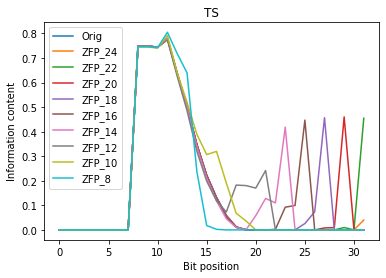

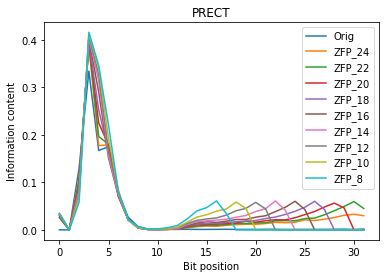

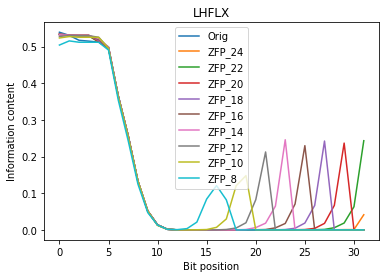

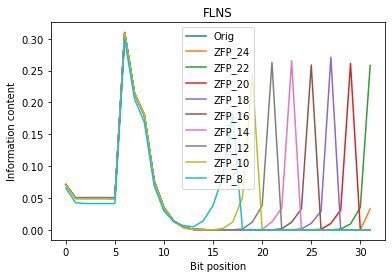

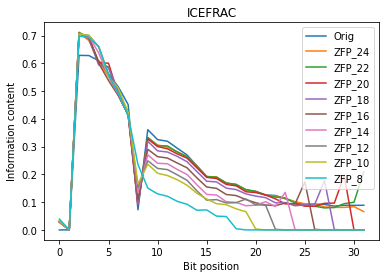

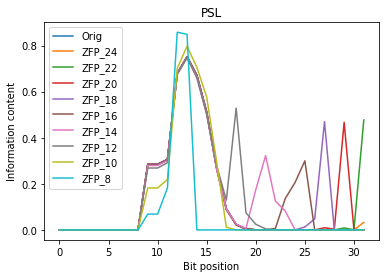

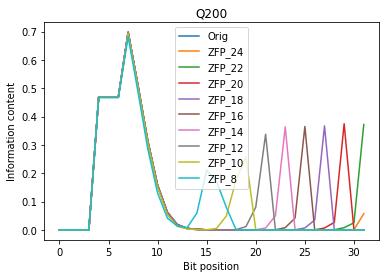

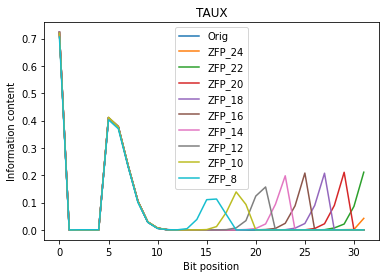

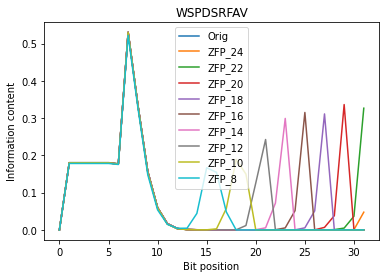

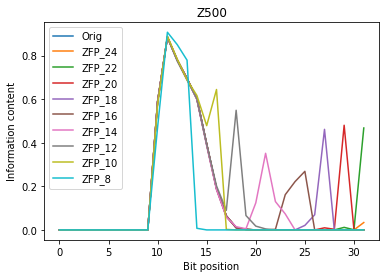

In [8]:
# ZFP
compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]
compression_levels = ["ZFP_" + str(x) for x in compression_levels]
compression_levels = ["Orig"] + compression_levels
for daily_variable in daily_variables:
    arr = climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        getbpe(arr, i, daily_variable, compression_levels)
    plt.title(daily_variable)
    plt.legend(compression_levels)
    plt.show()

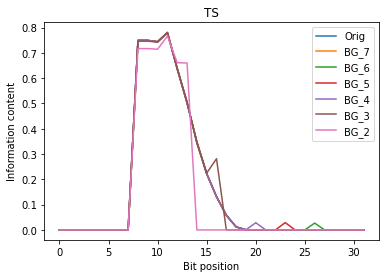

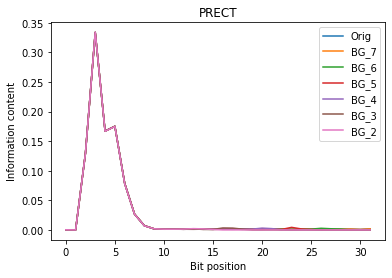

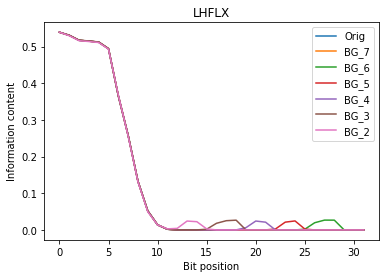

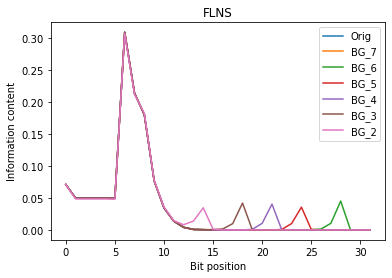

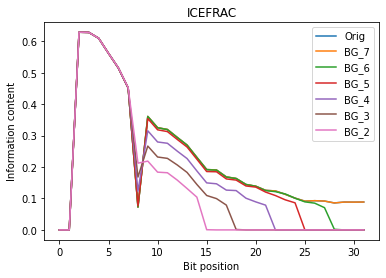

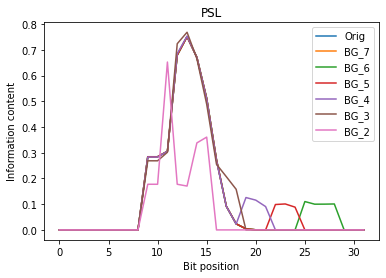

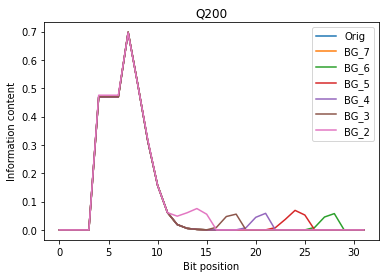

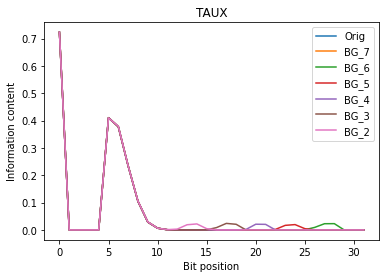

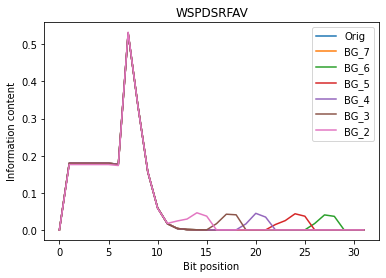

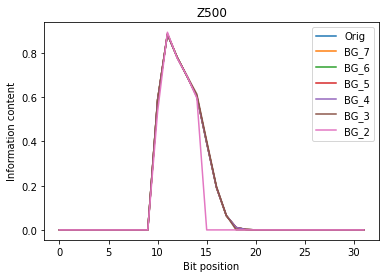

In [9]:
# BG
bg_compression_levels = [7, 6, 5, 4, 3, 2]
bg_compression_levels = ["BG_" + str(x) for x in bg_compression_levels]
bg_compression_levels = ["Orig"] + bg_compression_levels

for daily_variable in bg_daily_variables:
    arr = bg_climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        getbpe(arr, i, daily_variable, bg_compression_levels)
    plt.title(daily_variable)
    plt.legend(bg_compression_levels)
    plt.show()